In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re

from tqdm import tqdm

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import scale, minmax_scale
from scipy.stats import norm

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/nba/'
os.chdir(PATH)

## Read in

In [53]:
train = pd.read_csv(f'{PATH}/dataset/training_set.csv', encoding = 'ISO-8859-1')
test = pd.read_csv(f'{PATH}/dataset/holdout_set.csv', encoding = 'ISO-8859-1')

train.head()

,Engagements,Followers at Posting,Created,Type,Description
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...


In [54]:
len(train), len(test)

(7766, 1000)

## EDA on target

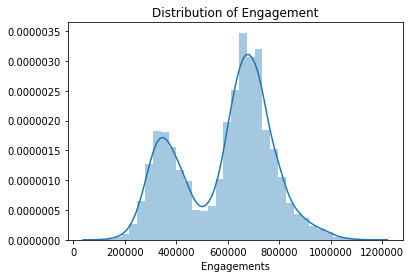

In [55]:
plt.plot(figsize=(8,6))
plt.title('Distribution of Engagement')
sns.distplot(train['Engagements'])
plt.show()

In [56]:
train.query('Engagements > 1_050_000').\
    sort_values('Engagements', ascending=False).\
    head()

,Engagements,Followers at Posting,Created,Type,Description
5921,1129585,26873604,2018-02-18 19:59:49 EST,Video,The captains meet for pregame #NBAAllStar talk...
3699,1077014,30719053,2018-09-16 12:06:15 EDT,Video,30 days from #KiaTipOff18... we flashback to @...
3876,1075434,30047470,2018-08-11 20:55:20 EDT,Video,At #1 on the TOP 60 DIMES... @kingjames! #NBAA...
5901,1067990,26873604,2018-02-18 23:32:14 EST,Video,@kingjames (29p/10r/8a) hoists the 2018 #NBAAl...
3762,1066099,30442523,2018-09-01 12:18:40 EDT,Video,Coming in at No.5...@kyrieirving SOMEHOW finds...


Highest `Engagements` at 1.1 million. Since `Engagement` is dependent on the number of followers, it would be better to take the percentage.

In [57]:
train['pct_engage'] = train['Engagements'] / train.iloc[:,1]

train.head()

,Engagements,Followers at Posting,Created,Type,Description,pct_engage
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,0.013576
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,0.016314
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,0.016314
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,0.019605
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,0.017884


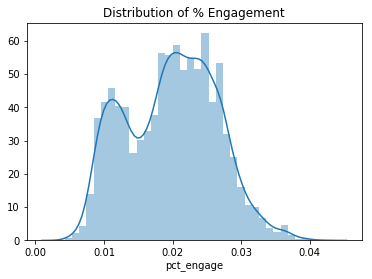

In [58]:
plt.plot(figsize=(8,6))
plt.title('Distribution of % Engagement')
sns.distplot(train['pct_engage'])
plt.show()

In [59]:
train.query('pct_engage > 0.038').\
    sort_values('pct_engage', ascending=False).\
    head()

,Engagements,Followers at Posting,Created,Type,Description,pct_engage
5921,1129585,26873604,2018-02-18 19:59:49 EST,Video,The captains meet for pregame #NBAAllStar talk...,0.042033
6867,1035841,25922734,2017-12-16 21:13:10 EST,Video,?? How did @kingjames do THAT?!?,0.039959
5901,1067990,26873604,2018-02-18 23:32:14 EST,Video,@kingjames (29p/10r/8a) hoists the 2018 #NBAAl...,0.039741
6100,1055161,26706824,2018-02-08 21:03:45 EST,Video,???? @kyrieirving ????,0.039509
5912,1059349,26873604,2018-02-18 22:20:39 EST,Video,@kingjames with the left! #NBAAllStar,0.039420


## Preprocessing

In [0]:
def str_to_date(s, split):
    return s.split(' ')[split]
  
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
      
def get_time_split(time):
    time_minute = time.split(':')[:2]
    return int(''.join(time_minute))
  
def get_hour(time):
    return int(time.split(':')[0])

In [0]:
def preprocess(df):
    df['date'] = df.apply(lambda x: str_to_date(x['Created'], 0), axis=1)
    df['time'] = df.apply(lambda x: str_to_date(x['Created'], 1), axis=1)
    df['tz'] = df.apply(lambda x: str_to_date(x['Created'], 2), axis=1)
    
    # get more features on date
    df['date'] = pd.to_datetime(df['date'])
    
    # date
    df['date_tsfm'] = pd.to_datetime(df['date'])
    
    add_datepart(df, 'date_tsfm')

    time_df = pd.get_dummies(df['Type'], 
                         prefix='Type')

    tz_df = pd.get_dummies(df['tz'],
                           prefix='tz')        

    # get only time and hour
    df['time_split'] = df['time'].apply(get_time_split)
    df['hour'] = df['time'].apply(get_hour)
    
    # convert 
    
    df = pd.concat([df, time_df, tz_df],
                    axis=1)
    
    return df

In [0]:
train = preprocess(train)
test = preprocess(test)

In [129]:
train.shape, test.shape

((7766, 52), (1000, 51))

In [130]:
train.head()

,Engagements,Followers at Posting,Created,Type,Description,pct_engage,time,tz,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,time_split,Type_Album,Type_Photo,Type_Video,tz_EDT,tz_EST,hour,Type_Album,Type_Photo,Type_Video,tz_EDT,tz_EST,date,date_tsfmYear,date_tsfmMonth,date_tsfmWeek,date_tsfmDay,date_tsfmDayofweek,date_tsfmDayofyear,date_tsfmIs_month_end,date_tsfmIs_month_start,date_tsfmIs_quarter_end,date_tsfmIs_quarter_start,date_tsfmIs_year_end,date_tsfmIs_year_start,date_tsfmElapsed,Type_Album,Type_Photo,Type_Video,tz_EDT,tz_EST
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,0.013576,23:30:51,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2330,0,0,1,1,0,23,0,0,1,1,0,2019-05-21,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,0,0,1,1,0
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,0.016314,22:53:33,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2253,0,0,1,1,0,22,0,0,1,1,0,2019-05-21,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,0,0,1,1,0
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,0.016314,22:19:58,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2219,0,0,1,1,0,22,0,0,1,1,0,2019-05-21,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,0,0,1,1,0
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,0.019605,22:02:41,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2202,0,0,1,1,0,22,0,0,1,1,0,2019-05-21,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,0,0,1,1,0
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,0.017884,20:47:49,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2047,0,0,1,1,0,20,0,0,1,1,0,2019-05-21,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,0,0,1,1,0


## EDA on features

In [141]:
train['tz'].value_counts()

EDT    3990
EST    3776
Name: tz, dtype: int64

In [142]:
train[(train['date'] < pd.datetime(2017, 11, 5)) & 
      (train['date'] > pd.datetime(2017, 3, 12))]['tz'].value_counts()

EDT    382
Name: tz, dtype: int64

Seems like we are having an equal split between `EDT` and `EST`. But after performing a check, daylight saving in year 2017 is between 3/12/2017 and 11/5/2017.  Hence, seeing that we only have `EDT` during daylight saving periods. This means we can assume 2300 EDT is the same as 2300 EST.

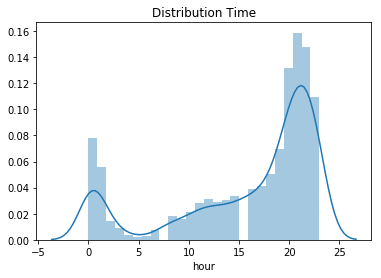

In [103]:
plt.plot(figsize=(8,6))
plt.title('Distribution Time')
# sns.distplot(train['time_split'])
sns.distplot(train['hour'])
plt.show()

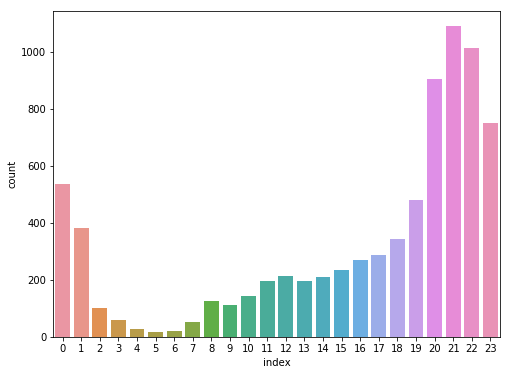

In [143]:
hour_val_cnt = train['hour'].value_counts().reset_index(name='count')

plt.figure(figsize=(8,6))
sns.barplot(x=hour_val_cnt['index'],
            y=hour_val_cnt['count'],)
plt.show()

Most posts are share between 8 PM to 12 AM.

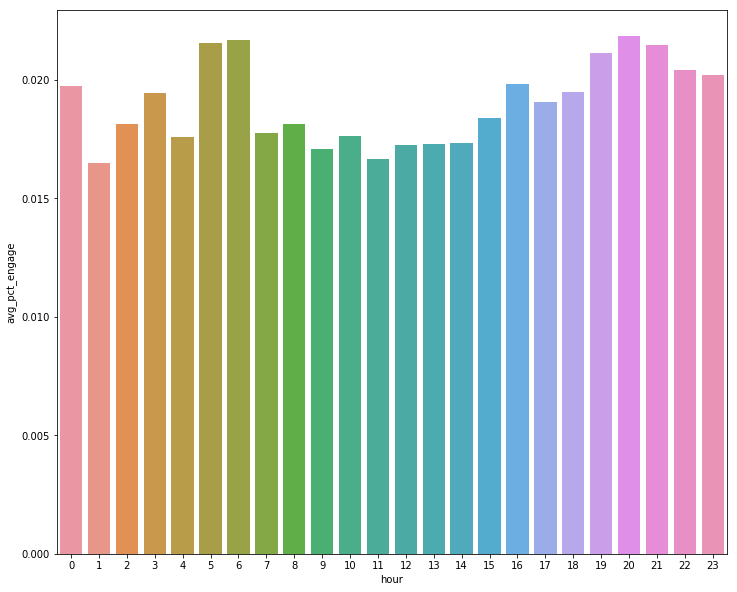

In [151]:
pct_engage_mean = train.groupby('hour')['pct_engage'].\
                          mean().\
                          reset_index(name='avg_pct_engage')

pct_engage_mean.head()

plt.figure(figsize=(12,10))
sns.barplot(x=pct_engage_mean['hour'],
            y=pct_engage_mean['avg_pct_engage'])
plt.show()

Interestingly, posts shared between 5 AM and 6 AM have surprisingly high `pct_engage` despite fewer posts are shared between those time.

In [153]:
train.query('hour == 5').sort_values('pct_engage', ascending=False).head()

,Engagements,Followers at Posting,Created,Type,Description,pct_engage,time,tz,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,time_split,Type_Album,Type_Photo,Type_Video,tz_EDT,tz_EST,hour,Type_Album,Type_Photo,Type_Video,tz_EDT,tz_EST,date,date_tsfmYear,date_tsfmMonth,date_tsfmWeek,date_tsfmDay,date_tsfmDayofweek,date_tsfmDayofyear,date_tsfmIs_month_end,date_tsfmIs_month_start,date_tsfmIs_quarter_end,date_tsfmIs_quarter_start,date_tsfmIs_year_end,date_tsfmIs_year_start,date_tsfmElapsed,Type_Album,Type_Photo,Type_Video,tz_EDT,tz_EST
6107,918745,26706824,2018-02-08 05:04:11 EST,Video,Coming through on both ends... @kingjames SWA...,0.034401,05:04:11,EST,2018,2,6,8,3,39,False,False,False,False,False,False,1518048000,504,0,0,1,0,1,5,0,0,1,0,1,2018-02-08,2018,2,6,8,3,39,False,False,False,False,False,False,1518048000,0,0,1,0,1
7393,844329,25358849,2017-11-04 05:40:47 EDT,Video,Above the rim... with the BEST DUNK from each ...,0.033295,05:40:47,EDT,2017,11,44,4,5,308,False,False,False,False,False,False,1509753600,540,0,0,1,1,0,5,0,0,1,1,0,2017-11-04,2017,11,44,4,5,308,False,False,False,False,False,False,1509753600,0,0,1,1,0
5965,883532,26847930,2018-02-17 05:03:53 EST,Video,Who had the best DUNK at the #KickstartRisingS...,0.032909,05:03:53,EST,2018,2,7,17,5,48,False,False,False,False,False,False,1518825600,503,0,0,1,0,1,5,0,0,1,0,1,2018-02-17,2018,2,7,17,5,48,False,False,False,False,False,False,1518825600,0,0,1,0,1
6076,876494,26743966,2018-02-10 05:07:34 EST,Video,??Dwyyyyyyyyyyaaaaane Waaaaaaaaadde!,0.032774,05:07:34,EST,2018,2,6,10,5,41,False,False,False,False,False,False,1518220800,507,0,0,1,0,1,5,0,0,1,0,1,2018-02-10,2018,2,6,10,5,41,False,False,False,False,False,False,1518220800,0,0,1,0,1
3340,913655,31419673,2018-10-19 05:23:53 EDT,Video,"@kingjames puts up 26 points, 12 boards & 6 as...",0.029079,05:23:53,EDT,2018,10,42,19,4,292,False,False,False,False,False,False,1539907200,523,0,0,1,1,0,5,0,0,1,1,0,2018-10-19,2018,10,42,19,4,292,False,False,False,False,False,False,1539907200,0,0,1,1,0


## Ideas

*   Tokenize text to get NBA team's Instagram. Perform `OneHotEncoding` on names.
*   Tokenize text to get players's Instagram. Perform `OneHotEncoding` on names.
*   Time, i.e., before or after game, playoffs or regular.
